In [1]:
%matplotlib notebook
from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
from matplotlib.colors import LogNorm

In [2]:
path = "/data/POL/HALOB/output_00417"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False,comov=True)

loading Dark matter..
loading Stars..
loading Gas..


In [3]:
centro_com = nbe.real_center(myhalo.st.pos3d,myhalo.st.mass)

In [4]:
#centro_com = np.array([6808.31255636, 6948.2450211, 6902.49371796])
myhalo.st.pos3d = myhalo.st.pos3d - centro_com
myhalo.dm.pos3d = myhalo.dm.pos3d - centro_com
myhalo.gs.pos3d = myhalo.gs.pos3d - centro_com

myhalo.st.r = np.sqrt((myhalo.st.pos3d[:,0]**2)+(myhalo.st.pos3d[:,1]**2)+(myhalo.st.pos3d[:,2]**2))
myhalo.dm.r = np.sqrt((myhalo.dm.pos3d[:,0]**2)+(myhalo.dm.pos3d[:,1]**2)+(myhalo.dm.pos3d[:,2]**2))
myhalo.gs.r = np.sqrt((myhalo.gs.pos3d[:,0]**2)+(myhalo.gs.pos3d[:,1]**2)+(myhalo.gs.pos3d[:,2]**2))


In [5]:
myhalo.dm.mass = myhalo.dm.mass[np.where(myhalo.dm.r<300.)]
myhalo.dm.pos3d = myhalo.dm.pos3d[np.where(myhalo.dm.r<300.)]
myhalo.dm.r = myhalo.dm.r[np.where(myhalo.dm.r<300)]

myhalo.st.mass = myhalo.st.mass[np.where(myhalo.st.r<300.)]
myhalo.st.pos3d = myhalo.st.pos3d[np.where(myhalo.st.r<300.)]
myhalo.st.r = myhalo.st.r[np.where(myhalo.st.r<300)]

myhalo.gs.mass = myhalo.gs.mass[np.where(myhalo.gs.r<300.)]
myhalo.gs.pos3d = myhalo.gs.pos3d[np.where(myhalo.gs.r<300.)]
myhalo.gs.r = myhalo.gs.r[np.where(myhalo.gs.r<300)]
myhalo.gs.rho = myhalo.gs.rho[np.where(myhalo.gs.r<300)]

In [6]:
myhalo.dm.vel3d = myhalo.dm.vel3d[np.where(myhalo.dm.r<300.)]

In [7]:

average = np.array([np.mean(myhalo.dm.vel3d[:,0]),
                    np.mean(myhalo.dm.vel3d[:,1]),
                    np.mean(myhalo.dm.vel3d[:,2])
                   ])
myhalo.dm.vel3d = myhalo.dm.vel3d - average

In [8]:
ok,myhalo.dm.rho,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),
                                    dtype=np.float32), myhalo.dm.mass)


myhalo.r200 =250.

In [9]:
ok,myhalo.st.rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),
                                    dtype=np.float32), myhalo.st.mass)

In [10]:
myhalo.rotate_galaxy()

In [11]:
def face_on_dm(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.dm.pos3d[:,0], 
                                       sim.dm.pos3d[:,1],
                                       bins=(edges, edges),
                                       weights=sim.dm.mass)
    result = H.T
    return result, edges

def face_on_st(sim,lims,points,thikness=.5):
    disk = (np.abs(sim.st.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[disk,0], 
                                       sim.st.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.st.mass[disk])
    result = H.T
    return result, edges

def face_on_gs(sim,lims,points,thikness=.9):
    disk = (np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disk,0], 
                                       sim.gs.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.gs.mass[disk])
    result = H.T
    return result, edges

def edge_on_st(sim,lims,points):
    #disk = sim.st.pos3d[:,2]
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[:,0], 
                                       sim.st.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=sim.st.mass)
    result = H.T
    return result, edges
    
def edge_on_gs(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=sim.gs.mass)
    result = H.T
    return result, edges
    

<IPython.core.display.Javascript object>


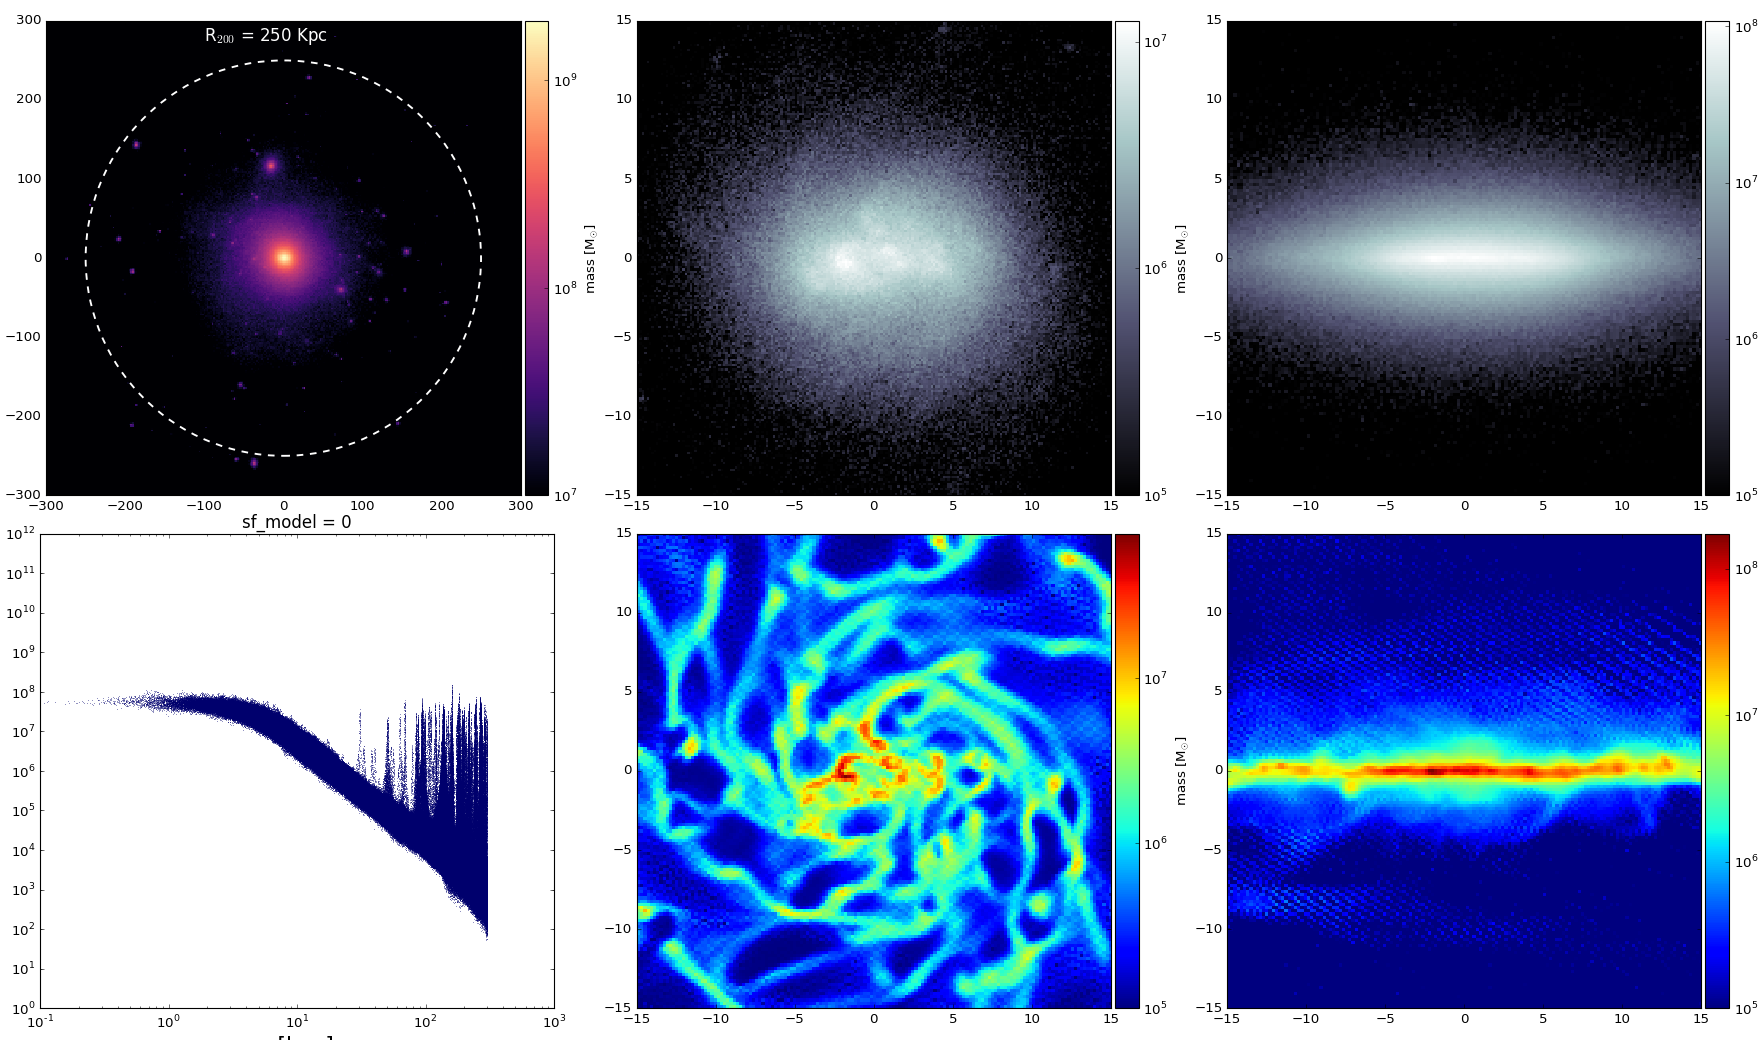

In [12]:

SF130_faceon, edges = face_on_dm(myhalo,[-1.2*myhalo.r200,1.2*myhalo.r200],300)
length = 15. 
fig,[[ax,ax1,ax2],[ax3,ax4,ax5]] = plt.subplots(2,3,figsize=[22,13])
fig.tight_layout(w_pad=3)

#######################################################################################################################3
mass_1 = ax.imshow(SF130_faceon+1e3, interpolation='nearest', origin='low',cmap="magma",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e7)
                  )
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

ax.add_artist(Circle(xy=(0, 0),radius=myhalo.r200,color='w',ls='--',lw=1.7,fill=False))
ax.text(-100,1.1*myhalo.r200,r"R$_{200}$ = "+str(int(myhalo.r200))+" Kpc ",color='w',fontsize=15)
#######################################################################################################################3

SF1140_faceOn,edges = face_on_st(myhalo,[-length,length],200)#H.T 

mass_2 = ax1.imshow(SF1140_faceOn+1e3, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
#######################################################################################################################3

SF1140_edgeOn,edges = edge_on_st(myhalo,[-length,length],150)#H.T 


mass_2 = ax2.imshow(SF1140_edgeOn+1e3, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

SF1140_faceOn,edges= face_on_gs(myhalo,[-length,length],150)#H.T 

mass_2 = ax4.imshow(SF1140_faceOn+1e5, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )

divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

#######################################################################################################################3

SF1140_edgeOn,edges = edge_on_gs(myhalo,[-length,length],150)#H.T 


mass_2 = ax5.imshow(SF1140_edgeOn, interpolation='nearest', origin='low',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )

divider = make_axes_locatable(ax5)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')


ax3.scatter(myhalo.dm.r, myhalo.dm.rho,s=0.5,alpha=0.5,lw=0)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylim([1e0,1e12])
ax3.set_xlabel(r"r [kpc]",fontsize=20)
ax3.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
ax3.set_title("sf_model = 0",fontsize=15)

# Tidal Radius

In [38]:
r_cen_ball = 10.
ball_mass = 1e6
M_inside = np.sum(myhalo.dm.mass[myhalo.dm.r<r_cen_ball])
M_inside += np.sum(myhalo.st.mass[myhalo.st.r<r_cen_ball])
M_inside += np.sum(myhalo.gs.mass[myhalo.gs.r<r_cen_ball])

r_t0 = (ball_mass / 3. /M_inside)**(1/3.)  * r_cen_ball
print M_inside
print "tidal r (a la Binney)= {0}".format(r_t0)
print "D to ball = {0}".format(r_cen_ball)

1.30574e+11
tidal r (a la Binney)= 0.136670185874
D to ball = 10.0


In [41]:
r_array = np.logspace(-0.,np.log10(4.*r_t0),60)
M_r=[(np.sum(myhalo.dm.mass[myhalo.dm.r<i])+np.sum(myhalo.gs.mass[myhalo.gs.r<i])+np.sum(myhalo.st.mass[myhalo.st.r<i])) for i in r_array]
f = interp1d(r_array,M_r)
der = np.diff(np.log(M_r))/np.diff(np.log(r_array))
diff_r = der[np.argmin(np.abs(r_array-r_cen_ball))]
print diff_r
r_t1 = (ball_mass / (1.-(diff_r/3.)) /3./M_inside)**(1/3.)  * r_cen_ball
print "tidal r (a la Stref)= {0}".format(r_t1)


2.31704733191
tidal r (a la Stref)= 0.223829505188


In [40]:
print np.argmin(np.abs(r_array-r_cen_ball))
print len(der)

0
59
